In [1]:
import openseespy.opensees as ops
import opsvis as ovs
import numpy as np
import matplotlib.pyplot as plt

In [73]:
ops.wipe()
ops.model('Basic','-ndm',2,'-ndf',3)


In [74]:
#data in SI
gap = 0.003
m1 = 75*10**3
m2 = 3000*10**3
T1 = 1.2
T2 = 0.3
c1 = 39270
c2 = 6.283*10**6
k1 = 2.056*10**6
k2 = 1.316*10**9
#damping ratio-->dr
dr1 = 0.05
dr2 = 0.05
E = 2*10**11
h1 = 5
bay = 4

In [75]:
#model creation
ops.node(1,0,0)
ops.node(2,bay,0)
ops.node(3,0,h1)
ops.node(4,bay,h1)
ops.fix(1,1,1,1)
ops.fix(2,1,1,1)
ops.equalDOF(3,4,2,3)# shear beam

In [76]:
ops.mass(3,0.5*m1)
ops.mass(4,0.5*m1)

In [77]:
Ic1 = k1/2*h1**3/(24*E)
Ib1 = Ic1
A1 = np.sqrt((12*Ic1))

In [78]:
a = 0.35
transftag = 1
ops.uniaxialMaterial('ViscousDamper',1,0,c1,a)
ops.geomTransf('Linear',transftag)
ops.element('elasticBeamColumn',1,1,3,A1,E,Ic1,transftag)
ops.element('elasticBeamColumn',2,2,4,A1,E,Ic1,transftag)
ops.element('elasticBeamColumn',3,3,4,A1,E,Ib1,transftag)
#damper
# ops.element('twoNodeLink',4,1,4,'-mat',1,'-dir',1)


In [79]:
ops.node(5,bay+gap,0)
ops.node(6,bay*2+gap,0)
ops.node(7,bay+gap,h1)
ops.node(8,bay*2+gap,h1)
ops.fix(5,1,1,1)
ops.fix(6,1,1,1)
ops.equalDOF(7,8,2,3)

In [80]:
ops.mass(7,0.5*m2)
ops.mass(8,0.5*m2)

In [81]:
Ic2 = k2/2*h1**3/(24*E)
Ib2 = Ic2
A2 = np.sqrt((12*Ic2))

In [82]:
ops.uniaxialMaterial('ViscousDamper',1000,0,c2,a)
ops.element('elasticBeamColumn',5,5,7,A2,E,Ic2,transftag)
ops.element('elasticBeamColumn',6,6,8,A2,E,Ic2,transftag)
ops.element('elasticBeamColumn',7,7,8,A2,E,Ib2,transftag)
#damper
#ops.element('twoNodeLink',8,5,8,'-mat',1000,'-dir',1)

In [83]:
## define DAMPING--------------------------------------------------------------------------------------
## apply Rayleigh DAMPING from $xDamp
## D=$alphaM*M + $betaKcurr*Kcurrent + $betaKcomm*KlastCommit + $beatKinit*$Kinitial
def setDamping():
    xDamp= 0.05		# 5% damping ratio
    lambda_ =  ops.eigen(1)[0]			# eigenvalue mode 1
    omega = pow(lambda_,0.5)
    alphaM =  0.				# M-prop. damping; D = alphaM*M
    betaKcurr =  0.         			# K-proportional damping;      +beatKcurr*KCurrent
    betaKcomm =  2.*xDamp/omega  	# K-prop. damping parameter;   +betaKcomm*KlastCommitt
    betaKinit =  0.		# initial-stiffness proportional damping      +beatKinit*Kini
    # define damping
    ops.rayleigh(alphaM, betaKcurr, betaKinit, betaKcomm) # RAYLEIGH damping

setDamping()

<Axes: >

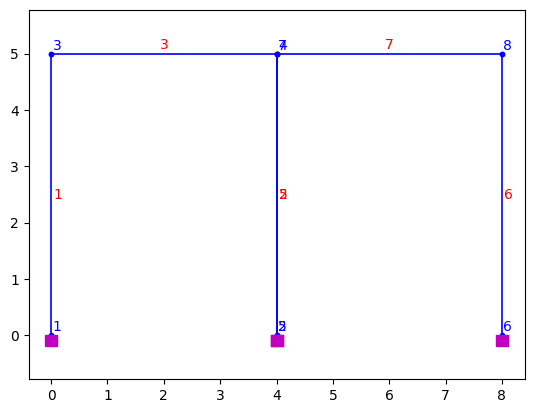

In [84]:
ops.rayleigh(0.01,0.02,0,0)
ovs.plot_model()

In [85]:
#kelvin voigt model
ops.node(9,bay,h1)
viscousID = 2
alpha = 1
ops.uniaxialMaterial('Viscous', viscousID, c2, alpha)
springID = 3
E0 = k2
c = c2
k = E0
ops.uniaxialMaterial('Elastic', springID, E0)
eppGAPMatID = 4
E = 2* E0
Fy = 250*10**6
kg = E
ops.uniaxialMaterial('ElasticPPGap', eppGAPMatID, 1*E, -1*Fy, -1*gap, 0.1)
parallelTag = 100
ops.uniaxialMaterial('Parallel', parallelTag, *[viscousID, springID])
ops.element('zeroLength', 101, *[4,9], '-mat', parallelTag, '-dir', *[1])
ops.element('twoNodeLink',102,*[9,7],'-mat',eppGAPMatID,'-dir',*[1])

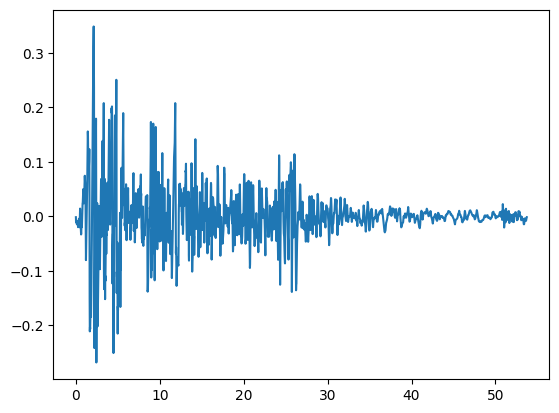

In [86]:
ground_motion = np.loadtxt('data/elcentro.txt',delimiter = " ")
plt.plot(ground_motion[:,0],ground_motion[:,1])
dt = ground_motion[:,0][1]

In [87]:
ops.timeSeries('Path', 1, '-dt', dt, '-values', *ground_motion[:,1], '-fact', 9.81)
ops.pattern('UniformExcitation', 200, 1, '-accel', 1)

In [88]:
#testing
ops.equalDOF(4,9,2,3)

In [89]:
eqLoad = 2
# ops.timeSeries('Path', eqLoad, '-dt', 0.01, '-filePath', "TakY.th", '-factor', g)
# ops.pattern('UniformExcitation', eqLoad, 1, '-accel', eqLoad)
# recorders

ops.recorder('Node', '-file', 'SDOF/left_corner_disp.txt', '-time', '-closeOnWrite','-node',4 , '-dof', 1, 'disp')
ops.recorder('Node', '-file', 'SDOF/mid_kv_disp.txt', '-time', '-closeOnWrite','-node',9 , '-dof', 1, 'disp')
ops.recorder('Node', '-file', 'SDOF/right_corner_disp.txt', '-time', '-closeOnWrite','-node',7 , '-dof', 1, 'disp')
ops.recorder('Node', '-file', 'SDOF/mid_kv_vel.txt', '-time', '-closeOnWrite','-node',9 , '-dof', 1, 'disp')
ops.recorder('Node', '-file', 'SDOF/left_corner_vel.txt', '-time', '-closeOnWrite','-node',4 , '-dof', 1, 'vel')
ops.recorder('Node', '-file', 'SDOF/right_corner_vel.txt', '-time', '-closeOnWrite','-node',7 , '-dof', 1, 'vel')
#ops.recorder('Element', '-file', 'eppDisplacement.txt', '-time', '-closeOnWrite','-ele',1 , '-dof', 1, 'deformation')
ops.recorder('Element', '-file', 'SDOF/Reactions_EPP.txt', '-time', '-closeOnWrite','-ele',101 , '-dof', 1, 'force')
ops.recorder('Element', '-file', 'SDOF/Reactions_KV.txt', '-time', '-closeOnWrite','-ele',102 , '-dof', 1, 'force')


# analysis
ops.constraints("Transformation")
ops.numberer("Plain")
ops.system("ProfileSPD")
tol = 1.e-8
maxNumIter = 50
ops.test("EnergyIncr", tol, maxNumIter)
ops.algorithm("ModifiedNewton")
ops.integrator("Newmark", .5, .25)
ops.analysis("Transient")

TmaxAnalysis = 10
DtAnalysis = 0.02

Nstep = int(TmaxAnalysis/DtAnalysis)

for i in range(Nstep):
    status = ops.analyze(1, DtAnalysis)
    # ovs.plot_defo()
    # plt.savefig(f'test_images/{(i+1)*DtAnalysis}s_{TmaxAnalysis}.png')
    # plt.close()
    print(f"Ground Motion - {i+1}/{Nstep}")
    if status != 0:
        print("Analysis failed trying Krylov Newton...")
        ops.algorithm('KrylovNewton')
        status = ops.analyze(1, DtAnalysis)
    if status != 0:
        print("Analysis failed trying with more iterations and less tolerance...")
        tol = 1.e-6
        maxNumIter = 100
        ops.system("BandSPD")
        ops.test("RelativeNormDispIncr", tol, maxNumIter)
        status = ops.analyze(1, DtAnalysis)
    if status!=0:
        print("Analysis failed trying Bryoden Algorithm")
        tol = 1.e-8
        maxNumIter = 50
        ops.test("EnergyIncr", tol, maxNumIter)
        ops.algorithm('Broyden')
        status = ops.integrator("HHT", 0.85, .5, .25)
        status = ops.analyze(1, DtAnalysis)
        #
    if status != 0:
        print("Breaking analysis")
        break
    
    ops.algorithm('ModifiedNewton')
    ops.system("ProfileSPD")
    tol = 1.e-10
    maxNumIter = 50    
    ops.test("EnergyIncr", tol, maxNumIter)
 

Ground Motion - 1/500
Ground Motion - 2/500
Ground Motion - 3/500
Ground Motion - 4/500
Ground Motion - 5/500
Ground Motion - 6/500
Ground Motion - 7/500
Ground Motion - 8/500
Ground Motion - 9/500
Ground Motion - 10/500
Ground Motion - 11/500
Ground Motion - 12/500
Ground Motion - 13/500
Ground Motion - 14/500
Ground Motion - 15/500
Ground Motion - 16/500
Ground Motion - 17/500
Ground Motion - 18/500
Ground Motion - 19/500
Ground Motion - 20/500
Ground Motion - 21/500
Ground Motion - 22/500
Ground Motion - 23/500
Ground Motion - 24/500
Ground Motion - 25/500
Ground Motion - 26/500
Ground Motion - 27/500
Ground Motion - 28/500
Ground Motion - 29/500
Ground Motion - 30/500
Ground Motion - 31/500
Ground Motion - 32/500
Ground Motion - 33/500
Ground Motion - 34/500
Ground Motion - 35/500
Ground Motion - 36/500
Ground Motion - 37/500
Ground Motion - 38/500
Ground Motion - 39/500
Ground Motion - 40/500
Ground Motion - 41/500
Ground Motion - 42/500
Ground Motion - 43/500
Ground Motion - 44/5

after: 50 iterations
 current EnergyIncr: 4670.16 (max: 1e-10) 	Norm deltaX: 0.00588836, Norm deltaR: 3.08293e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.06
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 8.56195e-08 (max: 1e-10) 	Norm deltaX: 1.10851e-08, Norm deltaR: 30.0234
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 2.08
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 16761.2 (max: 1e-10) 	Norm deltaX: 0.0111553, Norm deltaR: 5.8405e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 3
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 9.3841e-

Ground Motion - 181/500
Ground Motion - 182/500
Ground Motion - 183/500
Ground Motion - 184/500
Ground Motion - 185/500
Ground Motion - 186/500
Ground Motion - 187/500
Ground Motion - 188/500
Ground Motion - 189/500
Ground Motion - 190/500
Ground Motion - 191/500
Ground Motion - 192/500
Ground Motion - 193/500
Ground Motion - 194/500
Ground Motion - 195/500
Ground Motion - 196/500
Ground Motion - 197/500
Ground Motion - 198/500
Ground Motion - 199/500
Ground Motion - 200/500
Ground Motion - 201/500
Ground Motion - 202/500
Ground Motion - 203/500
Ground Motion - 204/500
Analysis failed trying Krylov Newton...
Ground Motion - 205/500
Ground Motion - 206/500
Analysis failed trying Krylov Newton...
Ground Motion - 207/500
Ground Motion - 208/500
Ground Motion - 209/500
Ground Motion - 210/500
Ground Motion - 211/500
Ground Motion - 212/500
Ground Motion - 213/500
Ground Motion - 214/500
Ground Motion - 215/500
Ground Motion - 216/500
Ground Motion - 217/500
Ground Motion - 218/500
Ground M

after: 50 iterations
 current EnergyIncr: 3048.62 (max: 1e-10) 	Norm deltaX: 0.00475752, Norm deltaR: 2.49086e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.08
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 3.25696e-07 (max: 1e-10) 	Norm deltaX: 2.16202e-08, Norm deltaR: 58.5571
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 4.12
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 21407.4 (max: 1e-10) 	Norm deltaX: 0.012607, Norm deltaR: 6.60054e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 5.22
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 4.772

Ground Motion - 292/500
Ground Motion - 293/500
Ground Motion - 294/500
Ground Motion - 295/500
Ground Motion - 296/500
Ground Motion - 297/500
Ground Motion - 298/500
Ground Motion - 299/500
Ground Motion - 300/500
Ground Motion - 301/500
Ground Motion - 302/500
Ground Motion - 303/500
Ground Motion - 304/500
Ground Motion - 305/500
Ground Motion - 306/500
Ground Motion - 307/500
Ground Motion - 308/500
Ground Motion - 309/500
Ground Motion - 310/500
Ground Motion - 311/500
Ground Motion - 312/500
Ground Motion - 313/500
Ground Motion - 314/500
Ground Motion - 315/500
Ground Motion - 316/500
Ground Motion - 317/500
Analysis failed trying Krylov Newton...
Ground Motion - 318/500
Ground Motion - 319/500
Analysis failed trying Krylov Newton...
Ground Motion - 320/500
Ground Motion - 321/500
Ground Motion - 322/500
Ground Motion - 323/500
Ground Motion - 324/500
Ground Motion - 325/500
Ground Motion - 326/500
Ground Motion - 327/500
Ground Motion - 328/500
Ground Motion - 329/500
Ground M

after: 50 iterations
 current EnergyIncr: 5.68871 (max: 1e-10) 	Norm deltaX: 0.000205511, Norm deltaR: 107598
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 8.5
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 5.48416e-07 (max: 1e-10) 	Norm deltaX: 2.80549e-08, Norm deltaR: 75.985
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 8.54
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 3401.37 (max: 1e-10) 	Norm deltaX: 0.00502523, Norm deltaR: 2.63103e+06
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
DirectIntegrationAnalysis::analyze() - the Algorithm failed at time 9.64
OpenSees > analyze failed, returned: -3 error flag
after: 50 iterations
 current EnergyIncr: 1.93458e-

In [90]:
left_node_disp=np.loadtxt('SDOF/left_corner_disp.txt',delimiter = " ")
right_node_disp=np.loadtxt('SDOF/right_corner_disp.txt',delimiter = " ")

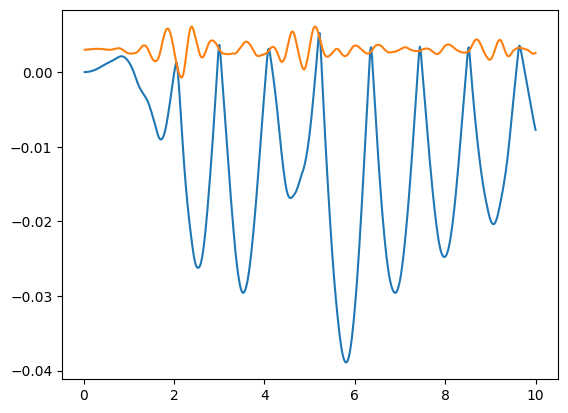

In [91]:
right_node_collided = right_node_disp[:,1] + gap
time = left_node_disp[:,0]
plt.plot(left_node_disp[:,0],left_node_disp[:,1])
plt.plot(right_node_disp[:,0],right_node_collided)


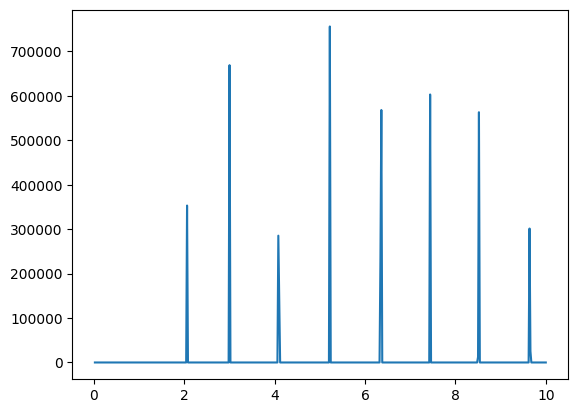

In [96]:
data1=np.loadtxt('SDOF/Reactions_EPP.txt',delimiter = " ")
data2=np.loadtxt('SDOF/Reactions_KV.txt',delimiter = " ")


plt.plot(data2[:,0],data2[:,1])
#plt.yticks(np.arange(0,7e6, 1e6))


#axis[2].plot(data2[:,0],data2[:,1])

In [93]:
left_node_vel=np.loadtxt('SDOF/left_corner_vel.txt',delimiter = " ")
mid_node_disp = np.loadtxt('SDOF/mid_kv_disp.txt', delimiter = " ")
mid_node_vel = np.loadtxt('SDOF/mid_kv_vel.txt', delimiter = " ")
right_node_vel=np.loadtxt('SDOF/right_corner_vel.txt',delimiter = " ")

In [94]:
#print(right_node_vel)
# left_node_disp, right_node_disp
force = np.zeros_like(left_node_disp[:, 1])
force = k * (left_node_disp[:,1] - mid_node_disp[:,1]) + c *(left_node_vel[:,1] - mid_node_vel[:,1])
collision = left_node_disp[:,1] - right_node_disp[:,1] - gap
iscollided = collision >= 0
force[~iscollided] = 0

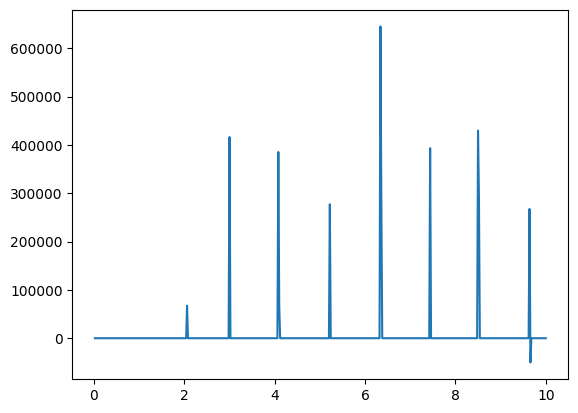

In [95]:
plt.plot(time, force)
#